In [1]:
import sys
sys.path.append('../src')
import pre_process as pre
import pre_process_demo_helper_fcns as pre_demo
import solver_demo_helper_functions as solver_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


## Analytical Solution for Cantilever Beam Tip Deflection

This example models a 2D cantilever beam fixed on the left edge and loaded with a uniform traction on the top edge. To validate the simulation, we compare the tip deflection with the classical analytical result from Euler–Bernoulli beam theory.

The analytical formula for the vertical tip deflection of a cantilever beam with a **uniformly distributed load** \( q \) applied over the entire length \( L \) is:

$$
w_{\text{tip}} = \frac{q L^4}{8 E I}
$$

Where:
- \( q \) is the load per unit length (traction)
- \( L \) is the beam length
- \( E \) is the Young's modulus
- \( I \) is the area moment of inertia

For a rectangular cross-section of height \( H \), the moment of inertia is:

$$
I = \frac{H^3}{12}
$$

---

### Plugged-in Analytical Value (from this example):

- q = 0.01 (traction load)
- L = 20 (beam length)
- H = 1 (beam height)
- E = 1 × 10⁵ (Young’s modulus)
- nu = 0.3 
- Effective Young's modulus:
$$
E_{\text{eff}} = \frac{E}{1 - \nu^2} = 109890.10989
$$
- Moment of inertia:
$$
I = \frac{H^3}{12} = \frac{1^3}{12} = 0.0833
$$

---

### Final Result:

Substituting into the formula:

$$
w_{\text{tip}} = \frac{0.01 \times 20^4}{8 \times 109890.10989 \times 0.0833} \approx -0.021840
$$


This analytical value provides a reference to validate the numerical result from the finite element simulation.


In [27]:

# Geometry and mesh
L = 20.0
H = 1.0
nx = 40
ny = 2
ele_type = "D2_nn8_quad"
ndof = 2

coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)


In [28]:

# Boundary conditions
boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
    coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
)

fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)
q = -0.01
dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)
fixed_nodes = fixed_left


In [29]:

# Material properties and solver
E = 1e5
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))
material_props = np.array([mu, kappa])

displacements_all, _ = hyperelastic_solver(
    material_props, ele_type, coords.T, connect.T,
    fixed_nodes, dload_info,
    nr_print=True, nr_num_steps=1, nr_tol=1e-10, nr_maxit=30
)


Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=3.619383e-05, tolerance=1.000000e-10
Iteration 2, Correction=5.835810e-04, Residual=7.779837e-04, tolerance=1.000000e-10
Iteration 3, Correction=4.869255e-07, Residual=7.962812e-10, tolerance=1.000000e-10
Iteration 4, Correction=3.052975e-14, Residual=1.140528e-13, tolerance=1.000000e-10


In [30]:

# Compute and compare tip deflection
final_disp = displacements_all[-1]
tip_node = None
tol = 1e-3
for i, (x, y) in enumerate(coords):
    if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
        tip_node = i
        break

assert tip_node is not None, "Tip node not found"
tip_disp_y = final_disp[ndof * tip_node + 1]

E_eff = E / (1 - nu**2)
I = H**3 / 12.0
w_analytical = q * L**4 / (8.0 * E_eff * I)
error = abs(tip_disp_y - w_analytical)

print(f"Computed tip deflection (y): {tip_disp_y:.6f}")
print(f"Analytical tip deflection:    {w_analytical:.6f}")
print(f"Absolute error:               {error:.6e}")


Computed tip deflection (y): -0.021817
Analytical tip deflection:    -0.021840
Absolute error:               2.321666e-05


Saved deformation GIF to basic_beam_deformation.gif


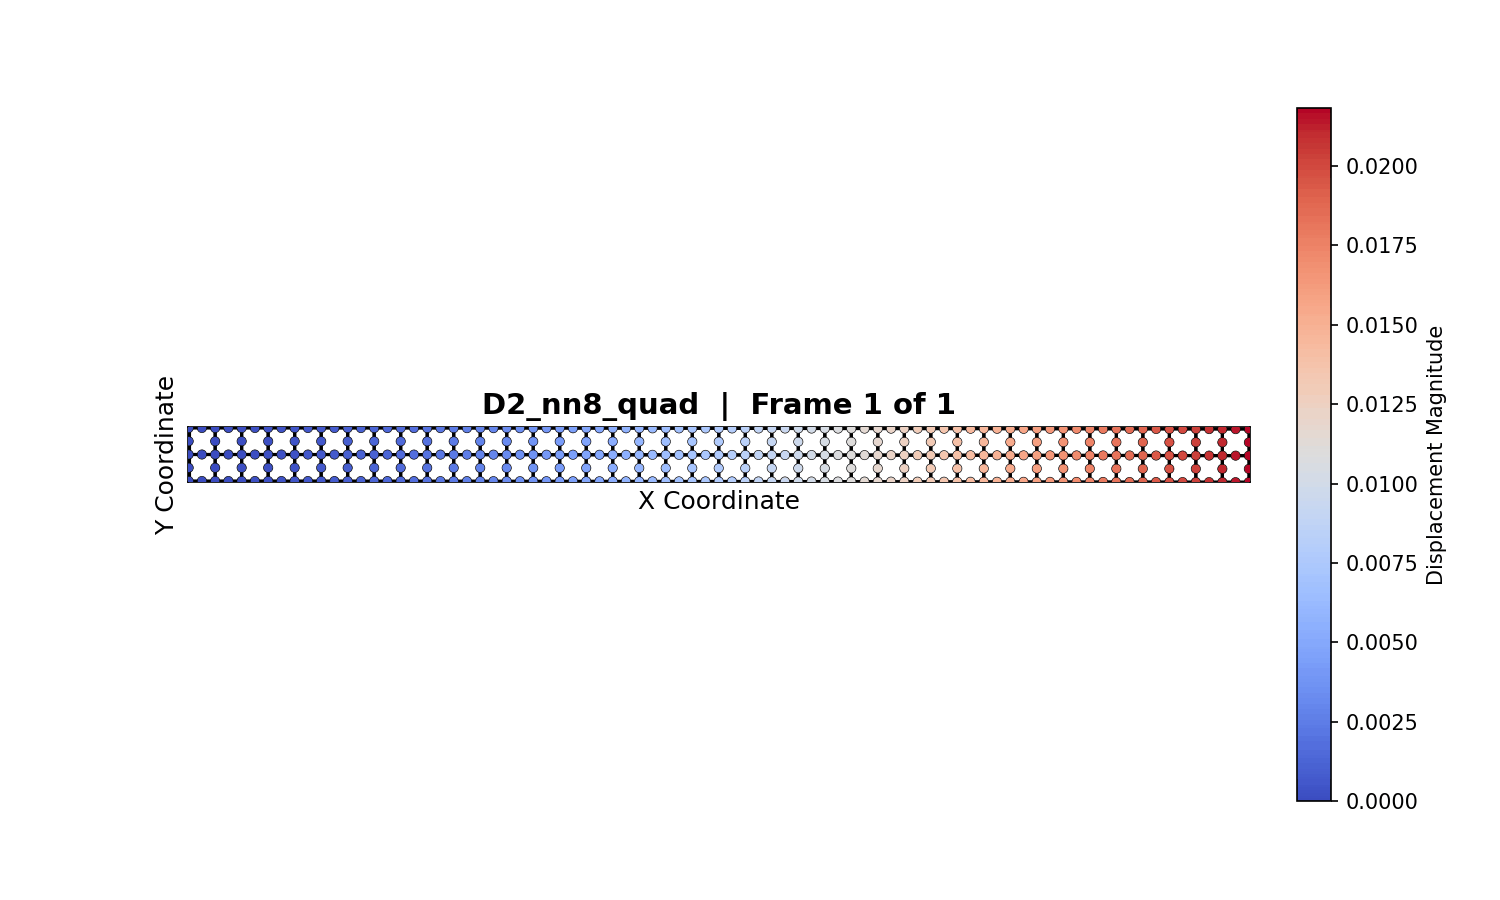

In [31]:

# Visualization
out_path = Path("basic_beam_deformation.gif")
viz.make_deformation_gif(displacements_all, coords, connect, ele_type, out_path)
print(f"Saved deformation GIF to {out_path}")
out_path = Path("basic_beam_deformation.gif")
viz.make_deformation_gif(displacements_all, coords, connect, ele_type, out_path)
from IPython.display import Image, display

display(Image(filename="basic_beam_deformation.gif"))
